# Learning Computer Vision and NLP with Image Captioning

## Motivation
This project stems from a keen interest in exploring the intersection of Computer Vision and Natural Language Processing. It serves as a self-guided exploration into these advanced areas of machine learning, aiming to build foundational knowledge and practical skills in developing intelligent image captioning systems.

## Project Overview
This project focuses on building an image captioning model utilizing the MS COCO dataset. The aim is to construct a model capable of generating descriptive and precise captions for a given image, reflecting a nuanced understanding of visual data.

## Dataset
* **Name**: MS COCO Dataset (2017)
* **Contents**: Images along with corresponding captions.
* **Characteristics**: The dataset includes a diverse range of images and contexts to challenge the model's understanding of real-world visuals.

## Tools and Libraries
Below are the imports used in this project, which include necessary libraries and frameworks essential for handling data, building, and evaluating the model:

In [2]:
%matplotlib inline
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import CocoCaptions
from pycocotools.coco import COCO
from torchvision import transforms
from PIL import Image
from torchtext.vocab import Vocab, vocab 
from torchtext.vocab import GloVe
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import string
import json
import nltk
from collections import Counter, defaultdict
from nltk.tokenize import word_tokenize
from torch.utils.tensorboard import SummaryWriter
from torchvision.models.resnet import ResNet50_Weights
#from torchvision.models import resnet18, ResNet18_Weights
from nltk.translate.bleu_score import corpus_bleu
import pickle


## Hyperparameters and Configuration Parameters
Below are the current hyperparameters and configuration parameters for the project. These values have been selected based on typical best practices and preliminary testing, but they may be adjusted as the project progresses to optimize the performance of the model.

In [3]:
config = {
    'batch_size': 16,
    'learning_rate': 0.0001,
    'epochs': 20,
    'num_workers' : 0,
    'embed_size': 200,
    'hidden_size': 512,
    #'vocab_size': 44849,
    'vocab_size': 21615, # GloVe 6B, 50D contains ~400,000 words #This is the size of the unfiltered (includes words not in glove)
    'num_layers': 2,  # Number of RNN layers
    'max_len': 50  # Maximum length of caption (based on MS COCO dataset, test max=49, val max=50)
}  
#Possible suggested layout I like, could use a similar version later to clean up code/make more modular  
'''
config = {
    'dataset': {
        'name': 'MS COCO',
        'version': '2017',
    },
    'data_handling': {
        'resize': (224, 224),
        'normalization': True,
        'tokenization': True,
        'lowercase': True,
        'strip_punctuation': True,
    },
    'model': {
        'encoder': {
            'architecture': 'ResNet18',  # Was ResNet50
        },
        'decoder': {
            'architecture': 'GRU',  # Was LSTM
            'layers': 1,  # Was 3
        },
    },
    'training': {
        'epochs': 5,  # Reduced for quicker prototyping
        'batch_size': 32,  # Same as before; adjust as needed
        'learning_rate': 0.001,  # Same as before
        'optimizer': 'Adam',  # Same as before
        'loss_function': 'CrossEntropyLoss',  # Same as before
    },
    'embedding': {
        'dimensionality': 100,  # Was 300; reducing might speed up
    }
}
'''

"\nconfig = {\n    'dataset': {\n        'name': 'MS COCO',\n        'version': '2017',\n    },\n    'data_handling': {\n        'resize': (224, 224),\n        'normalization': True,\n        'tokenization': True,\n        'lowercase': True,\n        'strip_punctuation': True,\n    },\n    'model': {\n        'encoder': {\n            'architecture': 'ResNet18',  # Was ResNet50\n        },\n        'decoder': {\n            'architecture': 'GRU',  # Was LSTM\n            'layers': 1,  # Was 3\n        },\n    },\n    'training': {\n        'epochs': 5,  # Reduced for quicker prototyping\n        'batch_size': 32,  # Same as before; adjust as needed\n        'learning_rate': 0.001,  # Same as before\n        'optimizer': 'Adam',  # Same as before\n        'loss_function': 'CrossEntropyLoss',  # Same as before\n    },\n    'embedding': {\n        'dimensionality': 100,  # Was 300; reducing might speed up\n    }\n}\n"

## Dataset Import and Visualization
In this section, the MS COCO dataset is imported for use in the project. This dataset includes a vast collection of images along with associated captions. To ensure the data has been imported correctly and to provide a visual understanding of the dataset, three random images and their corresponding captions are displayed below.

loading annotations into memory...
Done (t=0.61s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
118287


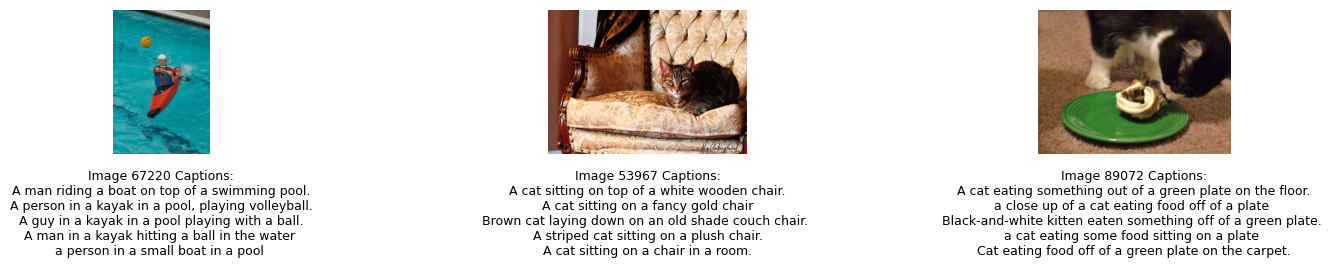

In [4]:
data_paths = {
    'train': {
        'root': r'C:\Users\jmp16\anaconda3\Scripts\ML_Project\train2017',
        'annFile': r'C:\Users\jmp16\anaconda3\Scripts\ML_Project\annotations\captions_train2017.json'
    },
    'val': {
        'root': r'C:\Users\jmp16\anaconda3\Scripts\ML_Project\val2017',
        'annFile': r'C:\Users\jmp16\anaconda3\Scripts\ML_Project\annotations\captions_val2017.json'
    },
    'test': {
        'root': r'C:\Users\jmp16\anaconda3\Scripts\ML_Project\test2017'  
    }
}


coco_dataset = CocoCaptions(root=data_paths['train']['root'], annFile=data_paths['train']['annFile'])
coco_dataset_validation = CocoCaptions(root=data_paths['val']['root'], annFile=data_paths['val']['annFile'])


#For testing purposes
#subset_data = Subset(coco_dataset, indices=range(50000))


#Visualization of 3 random images in training set
import random
print(str(len(coco_dataset)))
rand_indices = random.sample(range(len(coco_dataset)), 3)

images, targets = [], []
for index in rand_indices:
    img, target = coco_dataset[index]
    images.append(img)
    targets.append(target)



# Plot the images side by side
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Iterate over the axes, images, and targets to display images and print captions
for ax, img, target, idx in zip(axes, images, targets, rand_indices):
    ax.imshow(img) 
    ax.axis('off')
 # Combine all captions for the image into one string
    captions = '\n'.join(target)
    
    # Display the captions below the image
    ax.text(0.5, -0.7, f"Image {idx+1} Captions:\n{captions}", 
            size=9, ha="center", transform=ax.transAxes)
    
plt.tight_layout(pad=3.0)
plt.show()

### Vocabulary Initalization and Embedding Preparation

In [5]:



glove = GloVe(name="6B", dim=config['embed_size'])
'''
# GloVe's vocabulary and embeddings
glove_vocab = glove.itos  # list of words, indexed by their position in the vocabulary
embeddings = glove.vectors  # the actual vectors, indexed in the same way as glove_vocab

# Calculate the mean of all embeddings for certain special tokens
mean_embedding = torch.mean(embeddings, dim=0, keepdim=True)

# Special tokens and their initializations
special_tokens_init = {
    '<start>': mean_embedding,
    '<end>': mean_embedding,
    '<unk>': mean_embedding,
    '<pad>': torch.zeros(1, config['embed_size'])
}

# Add the special tokens to the vocabulary and embeddings matrix
for token, init in special_tokens_init.items():
    glove_vocab.append(token)
    embeddings = torch.cat([embeddings, init], 0)


word_to_idx = {word: idx for idx, word in enumerate(glove_vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

print(str(len(word_to_idx)) + " "+ str(len(idx_to_word)))
'''
###Function to pad captions to the max caption length in the batch
def collate_fn(data):
    # data is a list of tuples (image, caption)
    images, captions = zip(*data)
    #print(f"Type of img: {type(images)}, shape: {images.shape if torch.is_tensor(images) else 'Not a tensor'}")
    
    # Convert images to a single tensor
    images = torch.stack(images)  # Use torch.stack to convert tuple of tensors to a single tensor
    
    # Find the maximum caption length in the batch
    max_len = max(len(cap) for cap in captions)

    # Pad captions to the maximum length
    captions_padded = []
    for cap in captions:
        if len(cap) < max_len:
            cap += [word_to_idx['<pad>']] * (max_len - len(cap))
        captions_padded.append(cap)

    return images, torch.tensor(captions_padded)


#Vocab Testing
'''
for token in ['<start>', '<end>', '<unk>', '<pad>']:
    assert token in glove_vocab, f"{token} not found in vocabulary"

for i, word in enumerate(glove_vocab):
    assert i == word_to_idx[word], f"Inconsistent index for {word}"
    assert word == idx_to_word[i], f"Inconsistent word for index {i}"

assert embeddings.shape[0] == len(glove_vocab), "Mismatch in embedding shape"
'''



### Vocab Builder
'''
# Initialize a Counter to hold the word frequencies
word_freq = Counter()

# Loop through the COCO dataset to count word frequencies
for img, captions in coco_dataset:
    for caption in captions:
        # Tokenization logic can be as simple as splitting by space, or as complex as you like
        tokens = caption.lower().split(' ')
        word_freq.update(tokens)

# Create the final vocab including special tokens
#final_vocab = list(word_freq.keys())
final_vocab = [word for word in word_freq.keys() if word in glove_vocab]


special_tokens = list(special_tokens_init.keys())
final_vocab.extend(special_tokens)

# Now create the reduced embeddings tensor and the word-to-index and index-to-word mappings
reduced_embeddings = []
word_to_idx_reduced = {}
idx_to_word_reduced = {}

for i, word in enumerate(final_vocab):
    word_to_idx_reduced[word] = i
    idx_to_word_reduced[i] = word
    
    # Look up the GloVe embedding, fall back to mean or zeros if not found
    if word in special_tokens:
        #Gets the embedding from the initalized GloVe embeddings above, just have this cause I added it after the fact, and may end up deleting my own vocab if its causing issues
        reduced_embeddings.append(special_tokens_init[word])
    else:
        idx = word_to_idx.get(word, None)
        if idx is not None:
            reduced_embeddings.append(embeddings[idx])
        else:
            reduced_embeddings.append(mean_embedding if word != '<pad>' else torch.zeros(1, config['embed_size']))

reduced_embeddings = [embedding.unsqueeze(0) if len(embedding.shape) == 1 else embedding for embedding in reduced_embeddings]
reduced_embeddings = torch.stack(reduced_embeddings)


num_words_in_vocab = len(final_vocab)
print(f"Number of words in the vocabulary: {num_words_in_vocab}")
###########################

word_to_idx = word_to_idx_reduced
idx_to_word = idx_to_word_reduced

embeddings = reduced_embeddings
'''
# Helper functions to save/load vocab and embeddings
def save_vocab_and_embeddings(vocab, embeddings, file_path):
    data_to_save = {
        'vocab': vocab,
        'embeddings': embeddings  # Assume embeddings is a numpy array or a list that can be pickled
    }
    with open(file_path, 'wb') as f:
        pickle.dump(data_to_save, f)

def load_vocab_and_embeddings(file_path):
    with open(file_path, 'rb') as f:
        data_loaded = pickle.load(f)
        
    vocab = data_loaded['vocab']
    embeddings = data_loaded['embeddings']
    
    return vocab, embeddings


#save_vocab_and_embeddings(word_to_idx, embeddings, 'my_GloVe_vocab200.pkl')

#End Comment for Building/Saving Vocab


# To Load the Vocab - 
# comment out the 2 lines below if you want to Build/Save a new vocab
word_to_idx, embeddings = load_vocab_and_embeddings('my_GloVe_vocab200.pkl')
idx_to_word = {idx: word for word, idx in word_to_idx.items()}  #This is to generate captions from the model in the val/test phase

## Data Preprocessing

This section is dedicated to preparing the data for the model. The preprocessing steps are crucial for enhancing the model's performance and efficiency. Below are the steps undertaken for both image and caption data:

### Image Preprocessing:
1. **Resizing:** The images are resized to ensure uniformity in the dataset.
2. **Normalization:** Images are normalized to make the training process more stable and faster.

### Caption Preprocessing:
1. **Adding Tokens:** Each caption is appended with `<start>` and `<end>` tokens to signify the beginning and the end of the sentence.
2. **Lowercasing:** All characters in the captions are converted to lowercase to maintain consistency.
3. **Removal of Punctuation:** Unnecessary punctuation is removed from the captions.
4. **Tokenization:** Captions are broken down into individual words, creating a list of tokens.

### Custom Dataset Class:
A custom dataset class is implemented to efficiently handle and process the images and captions, ensuring an organized and streamlined data pipeline.


In [6]:
# Define the image transformations
img_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])


#Preprocessing the Captions to be ready for embedding with GloVe
def caption_preprocess(caption):
    # Add start and end tokens
    caption = '<start> ' + caption + ' <end>'
    
    # Convert to lowercase
    caption = caption.lower()
    
    # Remove punctuation
    remove_punct = string.punctuation.replace('<', '').replace('>', '')
    translator = str.maketrans('', '', remove_punct)
    caption = caption.translate(translator)
    
    # Tokenization (split the caption into words)
    tokens = caption.split()
    
    return tokens


#Custom Dataset to easily apply preprocessing to images and captions
class CustomCOCODataset(Dataset):
    def __init__(self, coco_dataset, img_transform=None, text_transform=None, mode='train'):
        self.coco_dataset = coco_dataset
        self.img_transform = img_transform
        self.text_transform = text_transform
        self.vocab = None  # Initially set vocab to None
        self.mode = mode  # 'train' or 'eval'

    def __len__(self):
        return len(self.coco_dataset)

    def __getitem__(self, idx):
        img, caption = self.coco_dataset[idx]
       
        if self.img_transform:
            img = self.img_transform(img)
        
        if self.mode == 'train':
            caption = caption[0]  # Take the first caption for training
            if self.text_transform:
                caption = self.text_transform(caption)
        else:
            caption = [self.text_transform(c) for c in caption]  # Take all captions for evaluation

        if self.vocab:  # If vocab is available, convert tokens to indices
            if self.mode == 'train':
                caption = [self.vocab.get(token, self.vocab['<unk>']) for token in caption]
            else:
                caption = [[self.vocab.get(token, self.vocab['<unk>']) for token in c] for c in caption]



        return img, caption
    
    def set_vocab(self, vocab):
        self.vocab = vocab  # Set the vocab



dataset = CustomCOCODataset(coco_dataset=coco_dataset, img_transform=img_preprocess, text_transform=caption_preprocess, mode='train')
dataset.set_vocab(word_to_idx)

Old vocab code - will delete


In [ ]:
'''
glove = GloVe(name="6B", dim=config['embed_size'])

# Helper functions to save/load vocab and embeddings
def save_vocab_and_embeddings(vocab, embeddings, file_path):
    data_to_save = {
        'vocab': vocab,
        'embeddings': embeddings  # Assume embeddings is a numpy array or a list that can be pickled
    }
    with open(file_path, 'wb') as f:
        pickle.dump(data_to_save, f)

def load_vocab_and_embeddings(file_path):
    with open(file_path, 'rb') as f:
        data_loaded = pickle.load(f)
        
    vocab = data_loaded['vocab']
    embeddings = data_loaded['embeddings']
    
    return vocab, embeddings


# Begin Comment for Building/Saving Vocab

counter = Counter()
for _, captions in dataset:  # using the dataset object to access tokenized captions
    counter.update(captions)
#print("counter: " + str(counter))

idx_to_word = {}
embeddings = []
threshold = 0  # Minimum word count threshold
index = 0
word_to_idx = {}

# Add special tokens
for token in ['<pad>', '<start>', '<end>', '<unk>']:
    word_to_idx[token] = index
    idx_to_word[index] = token
    embeddings.append(np.random.rand(config['embed_size']))  # Assign random embeddings
    index += 1

# Initialize the vocabulary and embeddings
word_to_idx = defaultdict(lambda: word_to_idx['<unk>'], word_to_idx)

for word, count in counter.items():
    if count >= threshold and word in glove.stoi:  # Word should be in GloVe vocab
        word_to_idx[word] = index
        idx_to_word[index] = word
        embeddings.append(glove[word])
        index += 1

print(word_to_idx.default_factory)  # Should not output None



# Convert embeddings list to numpy array
embeddings = np.array(embeddings)

# Freeze the defaultdict to prevent further modifications
word_to_idx.default_factory = None

save_vocab_and_embeddings(word_to_idx, embeddings, 'my_GloVe_vocab.pkl')

#End Comment for Building/Saving Vocab


# To Load the Vocab - 
# comment out the 2 lines below if you want to Build/Save a new vocab
word_to_idx, embeddings = load_vocab_and_embeddings('my_GloVe_vocab.pkl')
idx_to_word = {idx: word for word, idx in word_to_idx.items()}  #This is to generate captions from the model in the val/test phase

# Set the vocabulary in the dataset object
dataset.set_vocab(word_to_idx)
print(word_to_idx)




# GloVe's vocabulary and embeddings
glove_vocab = glove.itos  # list of words, indexed by their position in the vocabulary
glove_vectors = glove.vectors  # the actual vectors, indexed in the same way as glove_vocab

word_to_idx = {word: idx for idx, word in enumerate(glove_vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}






















###Function to pad captions to the max caption length in the batch
def collate_fn(data):
    # data is a list of tuples (image, caption)
    images, captions = zip(*data)
    #print(f"Type of img: {type(images)}, shape: {images.shape if torch.is_tensor(images) else 'Not a tensor'}")
    
    # Convert images to a single tensor
    images = torch.stack(images)  # Use torch.stack to convert tuple of tensors to a single tensor
    
    # Find the maximum caption length in the batch
    max_len = max(len(cap) for cap in captions)

    # Pad captions to the maximum length
    captions_padded = []
    for cap in captions:
        if len(cap) < max_len:
            cap += [word_to_idx['<pad>']] * (max_len - len(cap))
        captions_padded.append(cap)

    return images, torch.tensor(captions_padded)



train_loader = DataLoader(
    dataset=dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=config['num_workers'],
    collate_fn=collate_fn,
    pin_memory=True,
    #persistent_workers=True
)
'''

'\nglove = GloVe(name="6B", dim=config[\'embed_size\'])\n\n# Helper functions to save/load vocab and embeddings\ndef save_vocab_and_embeddings(vocab, embeddings, file_path):\n    data_to_save = {\n        \'vocab\': vocab,\n        \'embeddings\': embeddings  # Assume embeddings is a numpy array or a list that can be pickled\n    }\n    with open(file_path, \'wb\') as f:\n        pickle.dump(data_to_save, f)\n\ndef load_vocab_and_embeddings(file_path):\n    with open(file_path, \'rb\') as f:\n        data_loaded = pickle.load(f)\n        \n    vocab = data_loaded[\'vocab\']\n    embeddings = data_loaded[\'embeddings\']\n    \n    return vocab, embeddings\n\n\n# Begin Comment for Building/Saving Vocab\n\ncounter = Counter()\nfor _, captions in dataset:  # using the dataset object to access tokenized captions\n    counter.update(captions)\n#print("counter: " + str(counter))\n\nidx_to_word = {}\nembeddings = []\nthreshold = 0  # Minimum word count threshold\nindex = 0\nword_to_idx = {}\n\

## Model Definition

This section contains the definitions for the different components of the model architecture. The model is built upon an Encoder-Decoder framework. Further enhancements, such as attention mechanisms and transformers, are planned for future iterations.

### CNN Encoder

The encoding layer of the model employs a Convolutional Neural Network (CNN) which will be pretrained using ResNet50. The CNN acts as a feature extractor which translates the input images into a condensed feature representation, suitable for the decoding layer. Below is the implementation of the `CNN_Encoder`:


In [7]:
class CNN_Encoder(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(CNN_Encoder, self).__init__()
        self.train_CNN = train_CNN
        resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        modules = list(resnet.children())[:-1]  # removing the last classification layer
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.resnet.requires_grad_(self.train_CNN)

    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features


### RNN Decoder

The decoding layer is comprised of a Recurrent Neural Network (RNN) using the Long Short-Term Memory (LSTM) architecture. The feature vector generated by the `CNN_Encoder` initializes the hidden state of the LSTM, allowing the `RNN_Decoder` to utilize image information for caption generation. Below is the `RNN_Decoder` implementation:


In [8]:
class RNN_Decoder(nn.Module):
    def __init__(self, embeddings, vocab_size, embed_size, hidden_size, num_layers):
        super(RNN_Decoder, self).__init__()
        #print(embeddings.shape)  # Should print torch.Size([44849, 1, 100])
        embeddings = embeddings.squeeze(1)  # Remove the singleton dimension
        print(embeddings.shape)  # Should now print torch.Size([44849, 100])
        #self.embedding = nn.Embedding.from_pretrained(torch.tensor(embeddings, dtype=torch.float), freeze=True)
        self.embedding = nn.Embedding.from_pretrained(embeddings.clone().detach(), freeze=False)

        #self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.gru = nn.GRU(embed_size*2, hidden_size, num_layers, batch_first=True)  # Changed LSTM to GRU
        self.linear = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, features, captions, teacher_forcing_ration=0.5):
        embeddings = self.embedding(captions)
        #print("Shape of embeddings:", embeddings.shape)
        #inputs = torch.cat((features.unsqueeze(1), embeddings), dim=1)


        #print("Features shape:", features.shape)
        #print("Embeddings shape:", embeddings.shape)
        features = features.unsqueeze(1).repeat(1, embeddings.shape[1], 1)
        inputs = torch.cat((features, embeddings), dim=-1)
        #print("Inputs shape:", inputs.shape)


        #hiddens, _ = self.lstm(inputs)
        hiddens, _ = self.gru(inputs)  # Using GRU
        outputs = self.linear(hiddens)
        return outputs
        
        #possible more robust implementation
        '''
        batch_size = features.size(0)
        seq_len = captions.size(1)
        vocab_size = self.linear.out_features

        print("Vocab size(from decoder fpass):" + str(vocab_size))
        # Initialize tensor to hold outputs
        outputs = torch.zeros(batch_size, seq_len, vocab_size).to(features.device)

        inputs = features.unsqueeze(1)

        # Initialize hidden state
        hidden = None

        # Generate embeddings for captions
        embeddings = self.embedding(captions)

        for t in range(1, seq_len):  # Loop through each time-step in sequence
            # Forward pass
            hiddens, hidden = self.gru(inputs, hidden)  
            output = self.linear(hiddens.squeeze(1))
            outputs[:, t, :] = output

            # Determine if we will use teacher forcing or not
            use_teacher_forcing = random.random() < teacher_forcing_ratio

            # Get the highest predicted token from softmax output
            _, predicted = output.max(1)

            if use_teacher_forcing:
                # Use ground-truth token as the next input
                inputs = embeddings[:, t, :]
            else:
                # Use predicted token as the next input
                inputs = self.embedding(predicted)

            inputs = inputs.unsqueeze(1)

        return outputs
        '''
        
        
    def sample(self, features, max_len=config['max_len']):
        """Generate captions for given image features using greedy search."""
        
        output = []
        batch_size = features.size(0)
        hidden = None  # Initialize hidden state for LSTM and GRU
        


        start_token = torch.tensor([word_to_idx['<start>']], dtype=torch.long).unsqueeze(0).to(features.device)
        start_token_embedding = self.embedding(start_token)
        start_token_embedding = start_token_embedding.repeat(batch_size, 1, 1)  # make it the same batch size as features
        
        features = features.unsqueeze(1)  # Make it [batch_size, 1, embed_size]
        #print(features.shape, "- feature shape")
        #print(start_token_embedding.shape, "- start shape")
        inputs = torch.cat((features, start_token_embedding), dim=-1)  # Concatenate

        #print("CONCAT INPUT SHAPE GRU:", inputs.shape)

        #inputs = features.unsqueeze(1) - honestly don't know what this is here for, will probably delete
        #print("Shape of inputs before GRU post squeeze:", inputs.shape)

        for i in range(max_len):
            #hiddens, hidden = self.lstm(inputs, hidden)
            hiddens, hidden = self.gru(inputs, hidden)  # Using GRU
            #print(f"Shape of hiddens: {hiddens.shape}")
            outputs = self.linear(hiddens)
            #print("Shape of outputs:", outputs.shape)
            predicted = outputs.argmax(2)

            output.append(predicted)

            if (predicted.squeeze() == word_to_idx['<end>']).all():
                break

            next_input_embedding = self.embedding(predicted)
            #next_input_embedding = next_input_embedding.unsqueeze(1)
            #print("from sample, feature shape - ", features.shape)
            #print("from sample, next input embedding shape - ", next_input_embedding.shape)
            inputs = torch.cat((features, next_input_embedding), dim=-1)

        #output = torch.stack(output, 1)
        output = torch.cat(output, 1)  # Convert list of tensors to tensor
        return output

### Image Captioning Model

After defining the encoder and decoder, the next step is to integrate them into a single `Image_Captioning_Model`. This model will process the input image through the encoder, and then pass the resulting feature vector to the decoder to generate a corresponding caption. Below is the `Image_Captioning_Model` implementation:

In [9]:
class Image_Captioning_Model(nn.Module):
    def __init__(self, encoder, decoder):
        """
        Initialize the Image_Captioning_Model.
        :param encoder: The CNN encoder
        :param decoder: The RNN decoder
        """
        super(Image_Captioning_Model, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, captions):
        """
        Forward propagation.
        :param images: Images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        :param captions: Captions, a tensor of dimensions (batch_size, max_caption_length)
        :return: Outputs, a tensor of dimensions (batch_size, max_caption_length, vocab_size)
        """
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs


## Model Training
With the data preprocessed and the model architecture defined, the next step is to train the model. This process involves feeding the input data (images and captions) into the model, which will adjust its internal parameters to minimize the difference between its predictions and the actual captions. The training process will iterate over the entire dataset multiple times, in what are known as epochs.



In [10]:
train_loader = DataLoader(
    dataset=dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=config['num_workers'],
    collate_fn=collate_fn,
    pin_memory=True
    #persistent_workers=True 
)


# Initialize the encoder, decoder and the whole model
encoder = CNN_Encoder(config['embed_size'])
decoder = RNN_Decoder(embeddings, config['vocab_size'], config['embed_size'], config['hidden_size'], config['num_layers'])
model = Image_Captioning_Model(encoder, decoder)

# Move the model to the desired device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])


# Code to Compute the Validation loss per Epoch, does a forward pass with the model to check

def validation_loss(model, data_loader, criterion, vocab_size):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    total_loss = 0.0
    

    with torch.no_grad():
        for images, captions in data_loader:
            images, captions = images.to(device), captions.to(device)
            
            outputs = model(images, captions)

            outputs = outputs[:, 1:, :]  # shape is now (batch_size, sequence_length - 1, vocab_size)
            captions = captions[:, :-1]  # shape is now (batch_size, sequence_length - 1)
            
            # Create a mask for non-pad tokens in captions
            mask = (captions != word_to_idx['<pad>']).float()
            mask = mask.contiguous().view(-1)


            UNK_PENALTY = 2.0  
            predicted_unk = (outputs.argmax(dim=2) == word_to_idx['<unk>']).float()
            penalty = (predicted_unk * UNK_PENALTY).sum() / mask.sum()




            

            # Calculate the masked loss between predicted and actual captions
            loss = criterion(outputs.contiguous().view(-1, vocab_size), captions.contiguous().view(-1))
            masked_loss = ((loss + penalty) * mask).sum() / mask.sum()  # averaging only over non-pad token
            
            total_loss += masked_loss.item()
    
    avg_loss = total_loss / len(data_loader)
    return avg_loss


def generate_caption(model, image):
    model.eval()  # Set the model to evaluation mode
    image = image.to(device)  # Assuming image is already a torch tensor
    #print("image shape: " + str(image.shape))
    
    with torch.no_grad():
        features = model.encoder(image)  # Generate the features from the encoder and add time step dimension
        #print("Shape of features before GRU:", features.shape)

        #features = features.unsqueeze(0)

        sampled_ids = model.decoder.sample(features)  # Sample indices from decoder
        sampled_ids = sampled_ids[0].cpu().numpy()  # Convert tensor to numpy array and get first example
    
    # Convert the index list to a caption string
    sampled_caption = []
    for word_id in sampled_ids:
        word = idx_to_word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    model.train()  # Set the model back to training mode
    return ' '.join(sampled_caption)




val_dataset = CustomCOCODataset(coco_dataset=coco_dataset_validation, img_transform=img_preprocess, text_transform=caption_preprocess, mode='train')
val_dataset.set_vocab(word_to_idx)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    collate_fn=collate_fn
)

#If Training a fresh model, remove comment
start_epoch = 0

# Commented-out code to load the model
# Uncomment to use




checkpoint = torch.load("model_epoch_15.pth")  # Replace X with the epoch number
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1





writer = SummaryWriter()
'''

# Training Loop
def train_model(model, train_loader, criterion, optimizer, num_epochs, start_epoch, vocab_size):
    
    
    for epoch in range(start_epoch, num_epochs + start_epoch):
        print(f"Starting Epoch {epoch+1}")
        total_loss = 0.0
        model.train()  # Set the model to training mode


        for i, (images, captions) in enumerate(train_loader):
            print(f"Processing batch {i}")
            
            
            # Check the vocabulary in one of the batches
            # This prints out the actual words in the first sequence of the first batch of each epoch
            #i == 0 only prints first one, adjust as needed (% 2, % 10, etc)
            if i == 0:
                sampled_idx = captions[0, :].cpu().tolist()
                words = [idx_to_word[idx] for idx in sampled_idx]
                print("Sampled words from training batch:", words)
            # End of snippet
            
            #Mid training image captioning testing
            if i % 1750 == 0:  # Or use some other condition like i % 10 == 0 to log more frequently
                sampled_idx = captions[0, :].cpu().tolist()
                words = [idx_to_word[idx] for idx in sampled_idx]
                print("Sampled words from training batch:", words)

                # Log a random image and its caption to TensorBoard
                rand_idx = random.randint(0, images.size(0) - 1)
                image_to_log = images[rand_idx].cpu()
                caption_to_log = ' '.join([idx_to_word[idx] for idx in captions[rand_idx].cpu().numpy()])

                writer.add_image(f'Training/Image_at_epoch_{epoch}', image_to_log, global_step=i)
                writer.add_text(f'Training/Caption_at_epoch_{epoch}', caption_to_log, global_step=i)
                # Generate and log a caption using your model
                sample_image = images[rand_idx].unsqueeze(0)  # Take one random image from the batch
                
                generated_caption = generate_caption(model, sample_image)
                print(f"Generated caption: {generated_caption}")
    
                # Log generated caption to TensorBoard
                writer.add_text(f'Training/Generated_Caption_at_epoch_{epoch}', generated_caption, global_step=i)
                

            # Move images and captions tensors to the available device
            images, captions = images.to(device), captions.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images, captions)

            # Exclude the first output from each sequence in outputs
            outputs = outputs[:, 1:, :]  # shape is now (batch_size, sequence_length - 1, vocab_size)
            
            # Exclude the last token from each sequence in captions (as it does not have a corresponding output)
            captions = captions[:, :-1]  # shape is now (batch_size, sequence_length - 1)

            #print(outputs.shape)
            #print(captions.shape)


            # Create a mask for non-pad tokens in captions
            mask = (captions != word_to_idx['<pad>']).float()
            mask = mask.contiguous().view(-1)
            
            # Calculate the masked loss between predicted and actual captions
            loss = criterion(outputs.contiguous().view(-1, vocab_size), captions.contiguous().view(-1))


            # Penalty for predicting <unk> token
            UNK_PENALTY = 2.0  
            predicted_unk = (outputs.argmax(dim=2) == word_to_idx['<unk>']).float()
            penalty = (predicted_unk * UNK_PENALTY).sum() / mask.sum()




            masked_loss = ((loss + penalty) * mask).sum() / mask.sum()  # averaging only over non-pad token

            writer.add_scalar("Loss/train", masked_loss, epoch)
            
            # Backward pass and optimize
            masked_loss.backward()
            optimizer.step()
            
            
            #COMMENT THIS OUT TO SAVE MEMORY
            # Log model parameters and gradients
            #for name, param in model.named_parameters():
            #    writer.add_histogram(name, param, epoch)
            #    if param.grad is not None:  # Check if gradients exist
            #        writer.add_histogram(f"{name}.grad", param.grad, epoch)
            



            total_loss += masked_loss.item()
        
            # Delete tensors to free memory
            del images, captions, outputs

            # Clear GPU cache
            #torch.cuda.empty_cache()

        #Training Loss
        avg_loss = total_loss / len(train_loader)  # average loss for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

        val_loss = validation_loss(model, val_loader, criterion, config['vocab_size'])
        print(f"Validation Loss after Epoch {epoch}: {val_loss}")


        # Log the average loss for the epoch
        writer.add_scalar("Loss/Epoch_Avg", avg_loss, epoch)
        writer.add_scalar("Loss/Validation", val_loss, epoch)
        
        # Save the model weights after each epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
            'val_loss': val_loss,
        }, f"model_epoch_{epoch}.pth")




    # Now call the train_model function
train_model(model, train_loader, criterion, optimizer, config['epochs'], start_epoch, config['vocab_size'])

'''


torch.Size([21615, 200])


'\n\n# Training Loop\ndef train_model(model, train_loader, criterion, optimizer, num_epochs, start_epoch, vocab_size):\n    \n    \n    for epoch in range(start_epoch, num_epochs + start_epoch):\n        print(f"Starting Epoch {epoch+1}")\n        total_loss = 0.0\n        model.train()  # Set the model to training mode\n\n\n        for i, (images, captions) in enumerate(train_loader):\n            print(f"Processing batch {i}")\n            \n            \n            # Check the vocabulary in one of the batches\n            # This prints out the actual words in the first sequence of the first batch of each epoch\n            #i == 0 only prints first one, adjust as needed (% 2, % 10, etc)\n            if i == 0:\n                sampled_idx = captions[0, :].cpu().tolist()\n                words = [idx_to_word[idx] for idx in sampled_idx]\n                print("Sampled words from training batch:", words)\n            # End of snippet\n            \n            #Mid training image cap

## Model Evaluation
After training the model, it is crucial to evaluate its performance to ensure it is learning and generating suitable captions for images. In this project, we employ the BLEU score (Bilingual Evaluation Understudy Score), a standard metric for assessing the quality of text generated by machine translation systems.

The BLEU score compares the generated captions (candidate sentences) with the actual captions (reference sentences) and assigns a score between 0 and 1, where 1 represents a perfect match with the reference. A higher BLEU score indicates better performance of the image captioning model.

In this section, we will compute the BLEU scores for the captions generated by the model on the test dataset and visualize the model's performance over time using matplotlib.

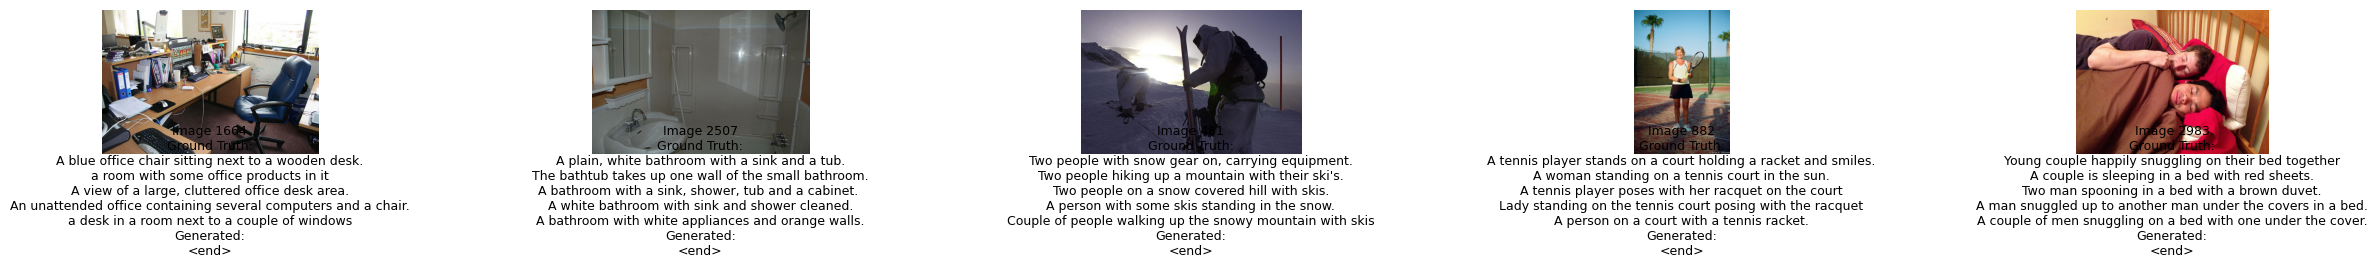

BLEU-4 score: 0.010528732030272875


['',
 '<start> av value av value av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents',
 '',
 '<start> av value av value av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents',
 '',
 '',
 '',
 '<start> av value av value av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents av cents',
 '',
 '<start> av value av value av value av value av value av value av value av value av value av value av value av value av value av value av value av cents av cents av cents av cents av cents av cents av cents av cents av cents',
 '',
 '',
 '',
 '',
 '<start> av value av value av value a

In [11]:
#The old, generate captions for 3 random images function, might check it out later, probably will just delete
'''
def generate_captions_for_images(model, images, idx_to_word):
    """
    Generates captions for a given list of images.

    :param model: trained captioning model
    :param images: list of image tensors
    :param idx_to_word: index to word mapping dictionary
    :return: list of generated captions as strings
    """
    # Move images tensors to the same device as the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    images = [img.to(device) for img in images]

    captions = []
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for img in images:
            features = model.encoder(img.unsqueeze(0))
            sampled_ids = model.decoder.sample(features)
            sampled_ids = sampled_ids[0].cpu().numpy()

            # Convert tensor outputs to words
            sampled_caption = []
            for word_id in sampled_ids:
                word = idx_to_word[word_id]  # Use idx_to_word dictionary here
                sampled_caption.append(word)
                if word == '<end>':
                    break
            caption = ' '.join(sampled_caption)
            captions.append(caption)

    return captions

# Usage
# Define the transformation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Apply the transformations to each image
tensor_images = [transform(img) for img in images]

# Now call the function with tensor_images instead of images
big_captions = generate_captions_for_images(model, tensor_images, idx_to_word)
for i, cap in enumerate(big_captions):
    print(f"Image {i+1} Caption: {cap}")


def convert_ids_to_words(actual_captions_list, idx_to_word):
    all_word_captions = []
    
    for captions in actual_captions_list:
        word_captions = []
        for cap in captions:
            words = [idx_to_word[word_id] for word_id in cap]
            word_captions.append(words)
        all_word_captions.append(word_captions)
    
    return all_word_captions
'''


# Sample 5 random indices from the validation set
rand_indices = random.sample(range(len(coco_dataset_validation)), 5)

# Initialize empty lists to hold images and targets
images, targets = [], []

# Fetch images and their captions based on the random indices
for index in rand_indices:
    img, target = coco_dataset_validation[index]
    images.append(img)
    targets.append(target)

# Plot the images side by side
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))

# Iterate over the axes, images, and targets to display images and print captions
for ax, img, target, idx in zip(axes, images, targets, rand_indices):
    ax.imshow(img)
    ax.axis('off')
    # Combine all captions for the image into one string
    captions = '\n'.join(target)
    
    # Convert the image to a PyTorch tensor and preprocess it (if required)
    img_tensor = img_preprocess(img).unsqueeze(0).to(device)  # Assuming you have a transform function and device
    # Generate a caption using your model
    generated_caption = generate_caption(model, img_tensor)

    # Display the captions below the image
    ax.text(0.5, -0.7, f"Image {idx+1}\nGround Truth:\n{captions}\nGenerated:\n{generated_caption}", 
            size=9, ha="center", transform=ax.transAxes)
    
# Show the final plot
plt.tight_layout(pad=3.0)
plt.show()














def generate_and_evaluate_captions(model, data_loader, idx_to_word):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_generated_captions = []
    all_actual_captions = []
    
    with torch.no_grad():
        for images, actual_captions_list in data_loader:
            #print(type(actual_captions_list))
            #print(actual_captions_list)


            



            
            images = images.to(device)  
            features = model.encoder(images)  # Extract features using encoder
            generated_captions = model.decoder.sample(features)  # Generate captions using decoder
            generated_captions = generated_captions.cpu().numpy()  # Move to CPU and convert to numpy


            # Process each generated caption
            for i in range(len(generated_captions)):
                sampled_caption = []
                for word_id in generated_captions[i]:
                    word = idx_to_word[word_id]
                    if word == '<end>':
                        break
                    sampled_caption.append(word)
                all_generated_captions.append(' '.join(sampled_caption[1:]))  # exclude the start token

        

                # Prepare ground truth captions for evaluation
                
                actual_captions = []
                for cap in actual_captions_list[i]:
                    actual_caption = []
                    for word_id in torch.tensor(cap, dtype=torch.long).cpu().numpy():
                        word = idx_to_word[word_id]
                        if word == '<end>':
                            break
                        actual_caption.append(word)
                    actual_captions.append(' '.join(actual_caption[1:]))  # exclude the start token

                all_actual_captions.append(actual_captions)

    # Compute BLEU-4 score
    bleu_score = corpus_bleu(all_actual_captions, all_generated_captions, weights=(0.25, 0.25, 0.25, 0.25))
    
    print(f"BLEU-4 score: {bleu_score}")

    return all_generated_captions

# Collate function to pad captions in the batch
def bleu_collate_fn(data):
    images, captions_list = zip(*data)
    images = torch.stack(images)

    max_len = max(len(cap) for captions in captions_list for cap in captions)

    batch_captions_padded = []
    for captions in captions_list:
        padded_captions = []
        for cap in captions:
            if len(cap) < max_len:
                cap += [word_to_idx['<pad>']] * (max_len - len(cap))  # Pad caption with '<pad>' tokens
            padded_captions.append(cap)
        batch_captions_padded.append(padded_captions)

    return images, batch_captions_padded







# This is separate from the val_dataset, because settingC the mode to eval access all 5 captions instead of just 1, 5 are needed for BLEU score, 1 is needed for val_loss

bleu_dataset = CustomCOCODataset(coco_dataset=coco_dataset_validation, img_transform=img_preprocess, text_transform=caption_preprocess, mode='eval')
bleu_dataset.set_vocab(word_to_idx)
bleu_loader = DataLoader(
    dataset=bleu_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    collate_fn=bleu_collate_fn
)


generate_and_evaluate_captions(model, bleu_loader, idx_to_word)





## Example Predictions

In this section, the trained model is utilized to generate captions for new, unseen images. This provides a practical demonstration of the model's capabilities and offers insight into its performance beyond numerical evaluation metrics. Observing the model's predictions on real-world examples can often reveal more nuanced information about its strengths and limitations.

For each image displayed below, the model’s predicted caption is presented alongside the image. This allows for a qualitative assessment of the model's captioning ability and aids in understanding the practical applicability of the model in real-world scenarios.


In [ ]:
test_dataset = CocoCaptions(root=data_paths['test']['root'], annFile=None, transform=img_preprocess)  # No annotations for test  

#look at the transform and moving this line to the top of the file ^^

# Initialize DataLoader
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=1,  # You can adjust the batch size if needed
    shuffle=False,
    num_workers=0  # You can adjust the number of workers if needed
)


# Generate captions for the test set and save to a JSON file
results = []

# Initialize COCO API object
coco = COCO(data_paths['test']['root'])  

# To get image ids
img_ids = coco.getImgIds()

#Testing model
model.eval()
with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):  # No captions in test set
        images = images.to(device)
        features = model.encoder(images)
        sampled_ids = model.decoder.sample(features)
        sampled_ids = sampled_ids[0].cpu().numpy()  # Convert tensor to numpy array and get the first item in batch
        
        # Decode word IDs to words
        sampled_caption = []
        for word_id in sampled_ids:
            word = idx_to_word[word_id]
            if word == '<end>':
                break
            sampled_caption.append(word)
        sentence = ' '.join(sampled_caption[1:])  # Exclude '<start>'
        
        # Prepare result for JSON
        img_id = img_ids[i]
        results.append({"image_id": img_id, "caption": sentence})

# Save results to JSON file
with open('generated_captions.json', 'w') as f:
    json.dump(results, f)

loading annotations into memory...


PermissionError: [Errno 13] Permission denied: 'C:\\Users\\jmp16\\anaconda3\\Scripts\\ML_Project\\test2017'

## Conclusion

This project has been an insightful journey for me, diving deep into the intricacies of machine learning, computer vision, and natural language processing. When I began this endeavor, I perceived Computer Vision and NLP as two separate domains. However, as the project unfolded, I realized the profound interconnectedness between them, which was a thrilling revelation.

Building an image captioning model, navigating the challenges, and witnessing its capabilities grow with each iteration has reinforced my passion for the world of Machine Learning. This experience has not just been about algorithms and architectures, but a testament to the potential of ML systems in making our world a better, more informed place.

The exploration and results obtained in this notebook underline the complexities and intricacies of image captioning. They also shed light on the performance and limitations of the model implemented. As I look to the future, I'm optimistic about delving deeper, refining this model, and unearthing more intersections between various AI domains.

The feedback and learnings from this work have provided me with a robust foundation for my continued journey in this fascinating field, and I'm eager to explore further, innovate, and contribute meaningfully to the world of AI.



## References

This section contains the list of references and resources used in the completion of this project. Proper citation acknowledges the contributions of others and provides a structured way to find additional information related to the topics and techniques discussed in this notebook. Each reference is listed with the appropriate citation, making it easy for readers to explore the source materials and gain deeper insights into the project and its underpinning methodologies.